### Испытание модели LightGBM (версия NotNaN)

Испытания LightGBM дали хороший прирост скорости, но практически не дали выигрыша в точности.

**Гипотеза**: удаление строк с NaN улучшит работу модели LighGBM

In [1]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error
import lightgbm as lgb
import pandas as pd
import os
os.chdir("D:/demo/ML/demo_dominicks")

from src.utils import prepare_training_data

baseline_df = pd.read_csv('data/baseline_dataset.csv', index_col=0)
baseline_df.head()

,com_code,upc,descrip,size,store,week,move,price,sale,age60,...,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
0,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,306,0,0.00,N,0.149192,...,0.087712,0.425324,10.140613,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417
1,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,307,1,2.99,N,0.149192,...,0.087712,0.425324,10.140613,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417
2,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,308,0,0.00,N,0.149192,...,0.087712,0.425324,10.140613,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417
3,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,309,0,0.00,N,0.149192,...,0.087712,0.425324,10.140613,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417
4,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,310,0,0.00,N,0.149192,...,0.087712,0.425324,10.140613,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417


In [2]:
baseline_df.dropna(inplace=True)
baseline_df.loc[:, 'size_cat'] = baseline_df['size'].astype('category').cat.codes.astype(int)
baseline_df.loc[:, 'descrip_cat'] = baseline_df['descrip'].astype('category').cat.codes.astype(int)
baseline_df.loc[:, 'sale_cat'] = baseline_df['sale'].astype('category').cat.codes.astype(int)
#test_df['pack'].cat.codes
baseline_df.head(5)

,com_code,upc,descrip,size,store,week,move,price,sale,age60,...,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5,size_cat,descrip_cat,sale_cat
0,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,306,0,0.00,N,0.149192,...,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417,19,120,3
1,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,307,1,2.99,N,0.149192,...,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417,19,120,3
2,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,308,0,0.00,N,0.149192,...,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417,19,120,3
3,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,309,0,0.00,N,0.149192,...,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417,19,120,3
4,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,310,0,0.00,N,0.149192,...,0.144374,0.296353,0.09633,3.55838,0.909091,1.075632,0.214417,19,120,3


In [3]:
X_train, X_test, y_train, y_test = prepare_training_data(baseline_df, 
                cat_cols=['descrip_cat', 'size_cat', 'sale_cat'],
                cols2drop=['com_code', 'upc', 'store', 'size', 'descrip', 'sale'],
                target_cols=['move'])

cat_features : 3 ['descrip_cat', 'size_cat', 'sale_cat']
num_features : 14 ['week', 'price', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hhlarge', 'workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5', 'cpwvol5']
targets ['move']


In [4]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["rmse", "l1"],
    "num_leaves": 512,
    "learning_rate": 0.19,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 1,
    "num_iterations": 1000,
    "num_threads": 24
    #"categorical_feature": "name:descrip_cat,size_cat,sale_cat"
}
'''
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=50, show_stdv=True)
            ]
        )
'''
gbm = lgb.train(
    params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=50, show_stdv=True)
            ]
)

d:\applications\miniconda3\envs\torch\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 5528944, number of used features: 17
[LightGBM] [Info] Start training from score 1.113026
Training until validation scores don't improve for 200 rounds
[50]	valid_0's rmse: 1.54185	valid_0's l1: 0.493668
[100]	valid_0's rmse: 1.52839	valid_0's l1: 0.48675
[150]	valid_0's rmse: 1.52275	valid_0's l1: 0.482797
[200]	valid_0's rmse: 1.51487	valid_0's l1: 0.48112
[250]	valid_0's rmse: 1.51398	valid_0's l1: 0.479198
[300]	valid_0's rmse: 1.51455	valid_0's l1: 0.478138
[350]	valid_0's rmse: 1.51424	valid_0's l1: 0.477515
[400]	valid_0's rmse: 1.51235	valid_0's l1: 0.477154
[450]	valid_0's rmse: 1.51585	valid_0's l1: 0.476932
[500]	valid_0's rmse: 1.51227	valid_0's l1: 0.476851
[55

In [5]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

print(f'\n Accuracy: {accuracy_score(y_test, y_pred.astype(int))}')


 Accuracy: 0.7612563990519708


In [6]:
gbm.save_model('model/02-lightgbm-model.txt', num_iteration=gbm.best_iteration)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

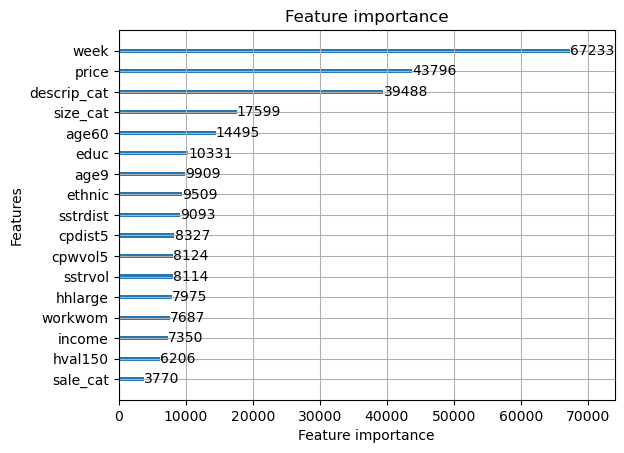

In [7]:
lgb.plot_importance(gbm)

#### Вывод
Незначительный прирост точности. Обе модели LightGBM (с NaN и без него) дают самую высокую значимость признакам недели, цены, марки и размера товара. Праздники, очевидно, могут влиять на продажи обезбаливающих. Стоит включить в датасет признак праздников, а также подробнее рассмотреть зависимость спроса на каждый товар от цены. Также стоит включить в датасет фактор смещения во времени. Вполне вероятно, что маркетинговые акции и праздники на текущей неделе серьезно влияют на продажи в последующие.